In [1]:
import numpy as np
from stats import LinearSolveStats, TimeStepStats
from stats import TimeStepStats
from matplotlib import pyplot as plt
from plot_utils import *

# data = load_data("../stats/fpm_2_closed_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_open_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_m_sliding_solver_1_numba.json")

data = load_data("../stats/fpm_0_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_0_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_0_open_solver_1_numba.json")

# data = load_data("../stats/fpm_1_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_1_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_1_open_solver_1_numba.json")

# data = load_data("../stats/fpm_01_open_solver_1_numba.json")
# data = load_data("../stats/fpm_01_sticking_solver_1_numba.json")


# data = load_data("../stats/fpm_1_sticking_direct_numba.json")

In [2]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
# from fpm_2_closed_m import make_model
# from fpm_2_closed import make_model
from fpm_0 import make_model
# from fpm_01 import make_model
# from fpm_1 import make_model
# from fpm_1_m import make_model


from pp_utils import make_row_col_dofs, make_reorder_contact

model = make_model()
model.prepare_simulation()

model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)

reorder = make_reorder_contact(model)


# model.assemble_linear_system()
# mat, rhs = model.linear_system

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


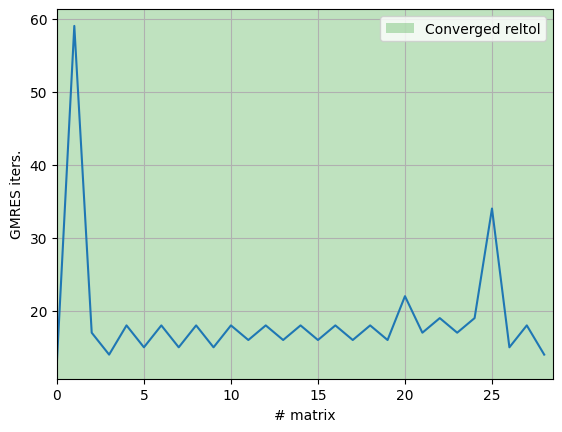

In [3]:
# %matplotlib ipympl
color_converged_reason(data)
plt.plot(get_gmres_iterations(data))
plt.ylabel('GMRES iters.')
plt.xlabel('# matrix')
# plt.yscale('log')
plt.legend()

In [4]:
mat_idx = 10
get_gmres_iterations(data)[mat_idx]

18

In [5]:
sticking, sliding, open_ = get_num_sticking_sliding_open(data)
transition = get_num_transition_cells(data)
sticking = sticking[mat_idx]
sliding = sliding[mat_idx]
open_ = open_[mat_idx]
transition = int(transition[mat_idx])
total = sticking + sliding + open_
print(f'{sticking = }', f'{sliding = }', f'open = {open_}', f'{transition = }', f'{total = }', sep='\n')

sticking = 14
sliding = 0
open = 0
transition = 14
total = 14


In [6]:
from plot_utils import *

mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(data, mat_idx)

# model.time_manager.dt = dt
# model.before_nonlinear_loop()
# model.before_nonlinear_iteration()
# model.equation_system.set_variable_values(state, time_step_index=0)
# model.equation_system.set_variable_values(iterate, iterate_index=0)
# model.rediscretize()
# model.assemble_linear_system()

# assert (model.linear_system[0] - mat).data.size == 0
# assert np.all(model.linear_system[1] == rhs)

# mat, rhs = model.linear_system

mat = mat[reorder]
rhs = rhs[reorder]

* GMRES right unprec_norm - 0.000125
* GMRES left prec_norm - 0.000118 (tol=1e-15)

Solve  took: 0.09
True residual decrease: 0.00011795733904680464


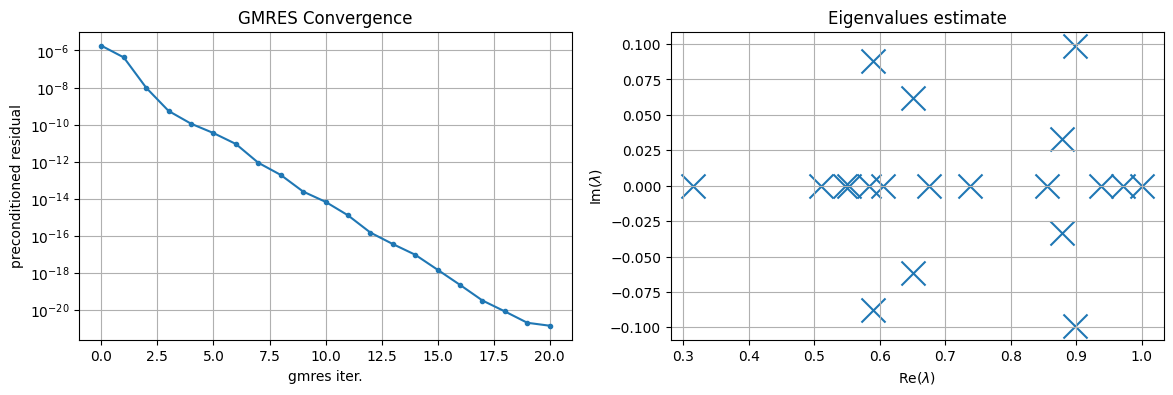

In [7]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(state, iterate_index=0)
perm_mat, prec_orig = model._prepare_solver()
solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs), tol=1e-15)

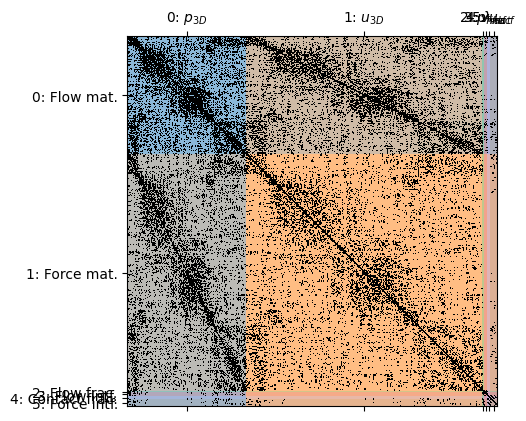

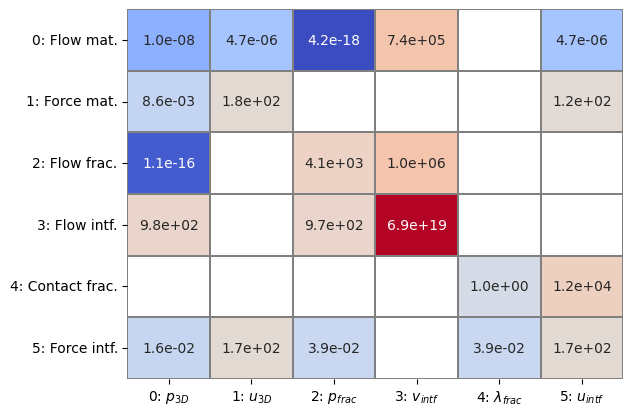

In [8]:
from block_matrix import BlockMatrixStorage
from pp_utils import correct_eq_groups

corrected_eq_dofs, corrected_eq_groups = correct_eq_groups(model)
    
J = BlockMatrixStorage(
    mat=mat,
    global_row_idx=corrected_eq_dofs,
    global_col_idx=model.var_dofs,
    groups_row=corrected_eq_groups,
    groups_col=model._variable_groups,
    # group_row_names=[r'$p_{2D}$', r'$u_{2D}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    # group_col_names=[r'$p_{2D}$', r'$u_{2D}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$']

    # group_row_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    # group_col_names=[r'$p_{3D}$', r'$u_{3D}$', '', '', '', '']

    group_row_names=[r'Flow mat.', r'Force mat.', r'Flow frac.', r'Flow intf.', r'Contact frac.', 'Force intf.'],
    group_col_names=[r'$p_{3D}$', r'$u_{3D}$', r'$p_{frac}$', r'$v_{intf}$', r'$\lambda_{frac}$', '$u_{intf}$']
)
# plt.figure(figsize=(8, 8))
J[:].color_spy()
J[:].plot_max()
# J[:].matshow()

## How accurately can direct solver solve it?

In [9]:
# Jinv = inv(J.mat)

In [10]:
# x = Jinv @ rhs
# norm(J.mat @ x - rhs) / norm(rhs)

0.00022737868114440732

* GMRES right unprec_norm - 0.00028 (tol=1e-9)
* GMRES left prec_norm - 0.0003 (tol=1e-9)

Solve  took: 0.08
True residual decrease: 0.0003034820260538276


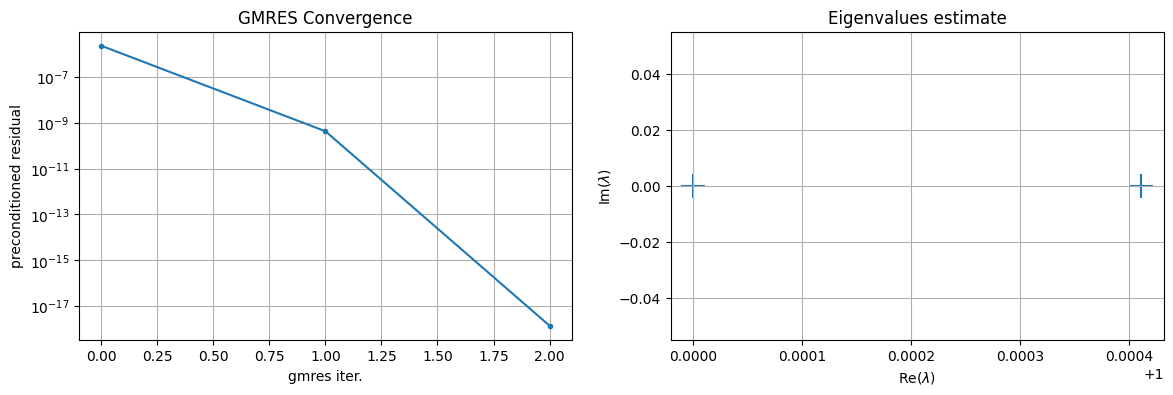

In [11]:
# solve_petsc(J.mat, Jinv, J.local_rhs(rhs), tol=1e-9)

# How is stabilized matrix different from the original one?

## Mechanics only [4, 5]

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


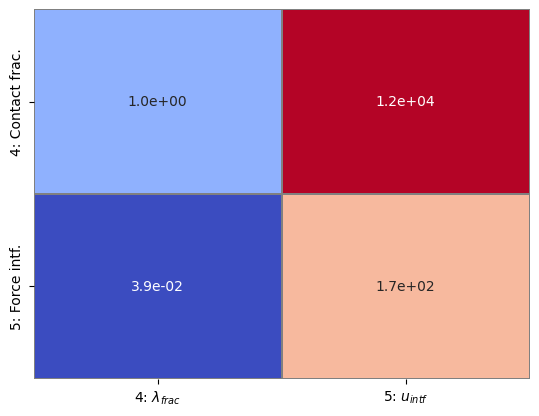

In [12]:
Jmech = J[[4,5]]

Jmech_stab = Jmech.copy()
J55_inv = inv_block_diag(Jmech_stab[[5]].mat, nd=model.nd)
Jmech_stab[[4]] = Jmech_stab[[4]].mat - Jmech_stab[4, 5].mat @ J55_inv @ Jmech_stab[5, 4].mat

# Jmech_stab[5, [4,5]] = 0
# Jmech_stab[5, 5] = csr_ones(J[5, 5].shape[0])
# Jmech_stab.mat.eliminate_zeros()

# Jmech_stab[4, [4, 5]] = Jmech_stab[4, [4, 5]].mat * 0.5
Jmech.plot_max()

In [13]:
Jmech_stab_inv = inv(Jmech_stab.mat)
print(cond(Jmech_stab_inv @ Jmech.mat))
print(cond(Jmech.mat @ Jmech_stab_inv))

2.1736147989069714
29752.8175695554


$ J \cdot P = \begin{bmatrix}
I & B \\
0 & I\end{bmatrix} $

$M = \begin{bmatrix}
I & -B \\
0 & I
\end{bmatrix}$

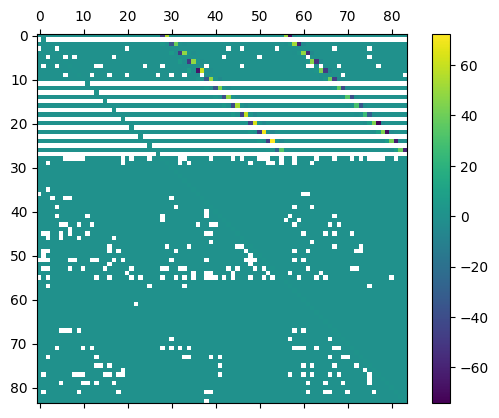

In [14]:
tmp = Jmech.empty_container()
tmp.mat = Jmech.mat @ Jmech_stab_inv
tmp.matshow(log=False)

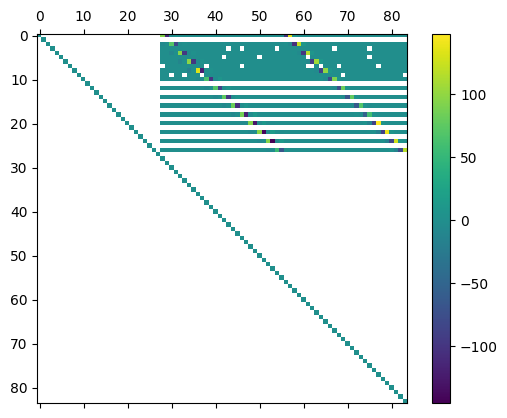

In [15]:
B = tmp[4, 5].mat
M = bmat(
    [
        [csr_ones(J[4, 4].shape[0]), -2 * B],
        [None, csr_ones(J[5, 5].shape[0])],
    ],
)
plot_mat(M, log=False)

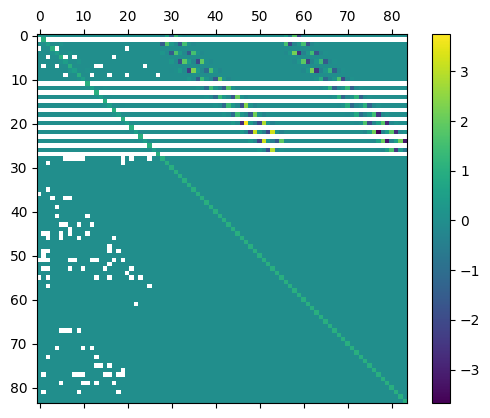

195.47822683261523

In [16]:
right = Jmech.empty_container()
right.mat = Jmech.mat @ Jmech_stab_inv @ M
# right.matshow_blocks(log=False)
right.matshow(log=False)
cond(right.mat)

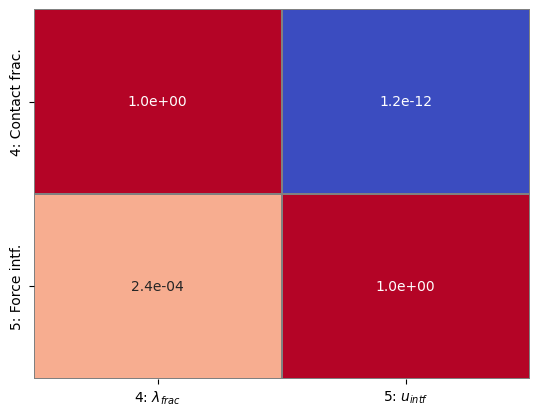

In [38]:
left = Jmech.empty_container()
left.mat = Jmech_stab_inv @ Jmech.mat
left.plot_max()

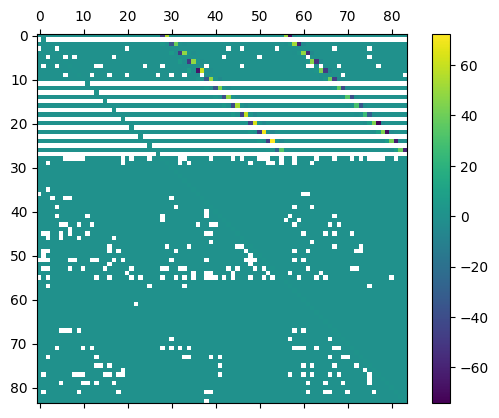

In [56]:
right = Jmech.empty_container()
right.mat = Jmech.mat @ Jmech_stab_inv
# right.matshow_blocks(log=False)
# right[5, 4].matshow(log=False)
# right.plot_max()
right.matshow(log=False)

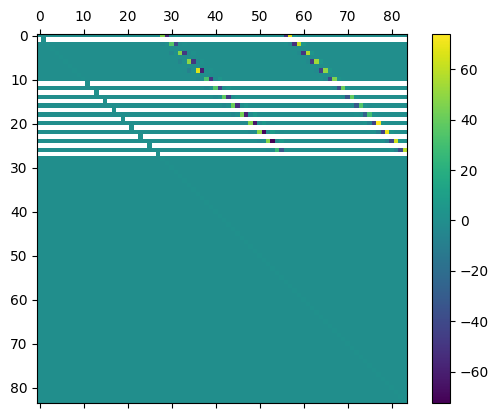

In [55]:
B = right[4, 5].mat
C = right[5, 4].mat
alpha = inv(csr_ones(B.shape[0]) - B @ C)
delta = inv(csr_ones(B.shape[1]) - C @ B)
beta = -B @ delta
gamma = -C @ alpha
stab = bmat(
    [
        [alpha, beta],
        [gamma, delta],
    ]
)
plot_mat(stab, log=False)

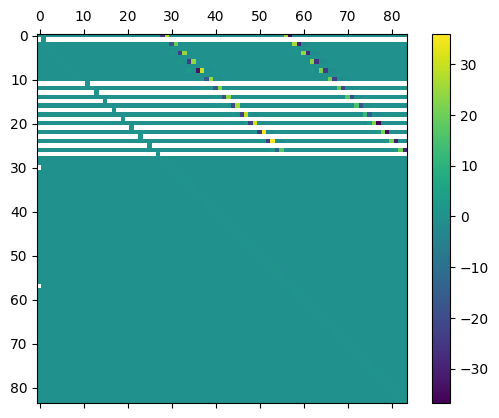

7334.669954856999

In [58]:
right = Jmech.empty_container()
right.mat = Jmech.mat @ Jmech_stab_inv @ stab
# right.matshow_blocks(log=False)
# right[5, 4].matshow(log=False)
# right.plot_max()
right.matshow(log=False)
cond(right.mat)

Solve  took: 0.0
True residual decrease: 6.12488098271194e-12


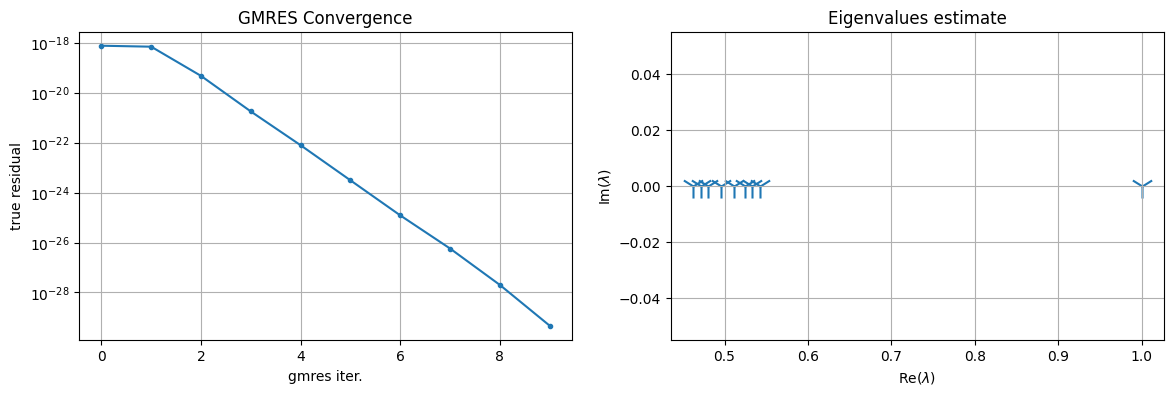

In [19]:
solve_petsc(Jmech.mat, Jmech_stab_inv, rhs=Jmech.local_rhs(rhs), pc_side='right')

## Test how accurate my approximations are

In [20]:
J55 = J[5, 5].mat
J54 = J[5, 4].mat
J45 = J[4, 5].mat
J44 = J[4, 4].mat

J44_stab = J44 - J45 @ inv(J55) @ J54

/home/porepy/simulations/plot_utils.py:104: RuntimeWarning: divide by zero encountered in log10
  mat = np.log10(abs(mat))


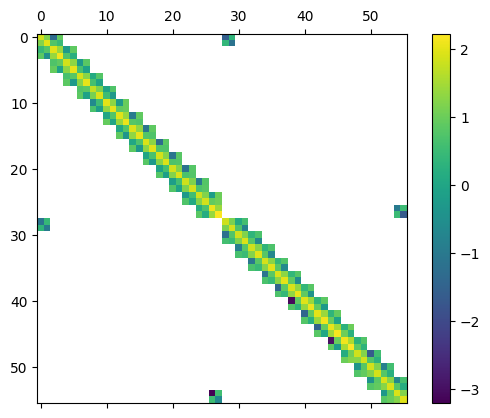

In [21]:
abs(J55).max()
plot_mat(J55)

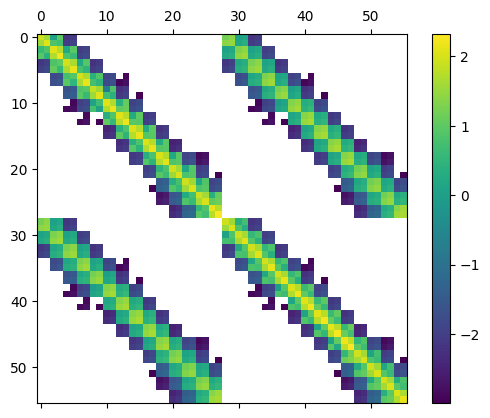

In [22]:
S55_stab = J55 - J54 @ inv(J44_stab) @ J45
abs(S55_stab).max()
S55_stab.data[abs(S55_stab.data) < 1e-3] = 0
plot_mat(S55_stab)

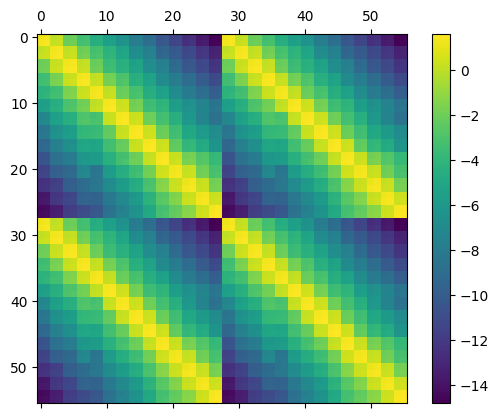

In [23]:
plot_mat(J54 @ inv(J44_stab) @ J45)

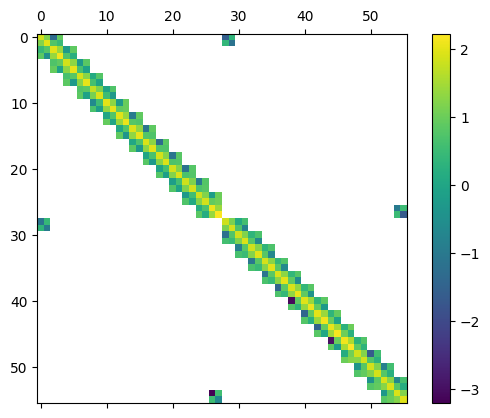

In [24]:
plot_mat(J55)

## What changes with the flow?

In [25]:
# Jfm = J[[2,1,4,5]]
Jfm = J[[2,4,5]]

Jfm_stab = Jfm.copy()
Jfm_stab[[4]] = Jfm_stab[[4]].mat - Jfm_stab[4, 5].mat @ J55_inv @ Jfm_stab[5, 4].mat
# Jfm_stab[4, [2, 4, 5]] = Jfm_stab[4, [2, 4, 5]].mat * 0.5

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [26]:
Jfm_inv = inv(Jfm.mat)
print(cond(Jfm_inv @ Jfm_stab.mat))
print(cond(Jfm_stab.mat @ Jfm_inv))

2.1736148921356304
2.337233683949663e+20


In [27]:
Jfm_stab_inv = inv(Jfm_stab.mat)
print(cond(Jfm_stab_inv @ Jfm.mat))
print(cond(Jfm.mat @ Jfm_stab_inv))

2.1736785882932046
2.337196777963067e+20


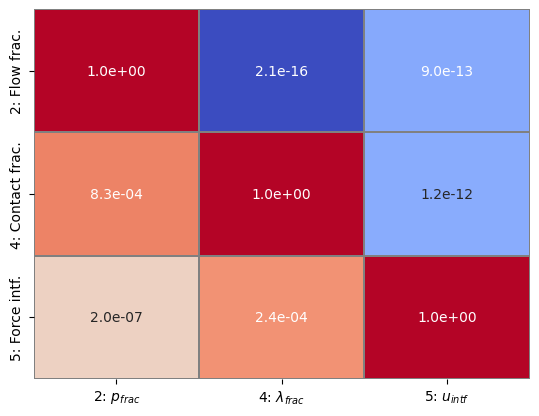

In [28]:
res = Jfm_stab.empty_container()
res.mat = Jfm_stab_inv @ Jfm.mat
# res.matshow_blocks(log=False)
res.plot_max()

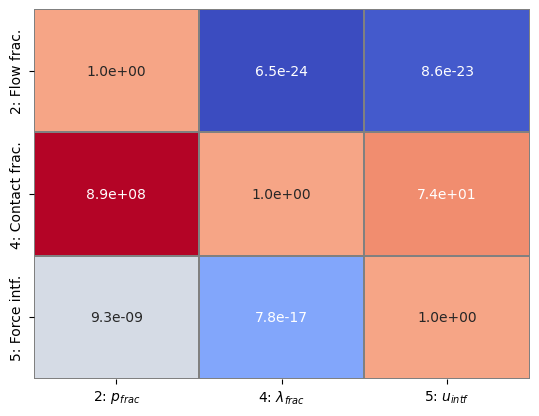

In [29]:
res = Jfm_stab.empty_container()
res.mat = Jfm.mat @ Jfm_stab_inv
# res.matshow_blocks(log=False)
res.plot_max()

* $\tilde{A}^{-1} \cdot A$ - ok (left prec)
* $A \cdot \tilde{A}^{-1}$ - bad (right prec)

Q: Is GMRES left or right? 

A: Was right and didn't work, now left and works?

Solve  took: 0.0
True residual decrease: 0.0013648585109271457


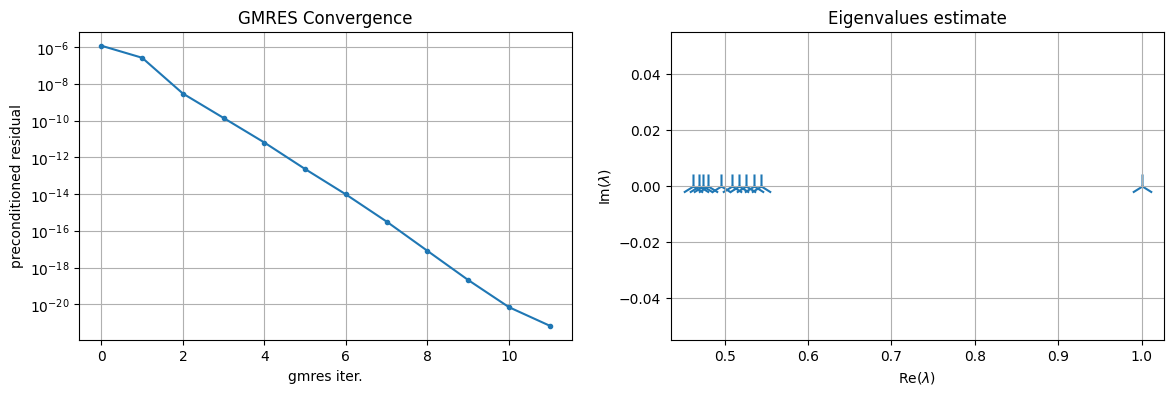

In [30]:
solve_petsc(Jfm.mat, Jfm_stab_inv, rhs=Jfm.local_rhs(rhs), tol=1e-15, pc_side='left')

Solve  took: 0.0
True residual decrease: 1.5590416111527154
PETSc Converged Reason: -5
lambda min: 26.89591273490603


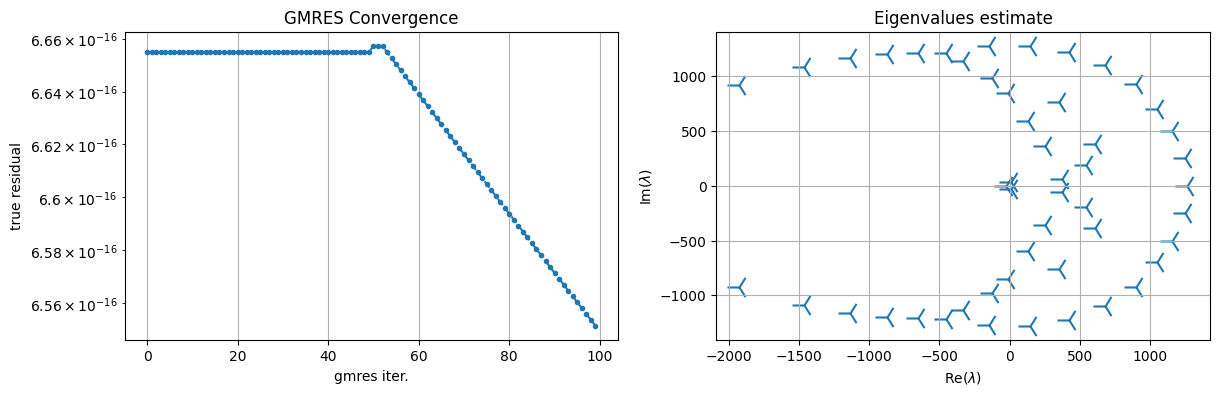

In [31]:
solve_petsc(Jfm.mat, Jfm_stab_inv, rhs=Jfm.local_rhs(rhs), tol=1e-15, pc_side='right')

# M_inv

In [32]:
class Minv:
    def __init__(self, J55_inv, J45):
        self.J55_inv = J55_inv
        self.J45 = J45
        nd = J55_inv.shape[0] + J45.shape[0]
        self.shape = nd, nd

    def dot(self, x):
        sep = self.J45.shape[0]
        x4 = x[:sep]
        x5 = x[sep:]
        res4 = 2 * x4 - self.J45 @ self.J55_inv.dot(x5)
        return np.concatenate([res4, x5])
    

class Linv:
    def __init__(self, J55_inv, J54):
        self.J55_inv = J55_inv
        self.J54 = J54
        nd = J55_inv.shape[1] + J54.shape[1]
        self.shape = nd, nd

    def dot(self, x):
        sep = self.J54.shape[1]
        x4 = x[:sep]
        x5 = x[sep:]
        tmp = -self.J55_inv.dot(self.J54 @ x4)
        return np.concatenate([2 * x4, x5 + tmp])
    

class MultiplicativePrec:

    def __init__(self, first, second):
        self.first = first
        self.second = second
        assert first.shape == second.shape
        self.shape = first.shape

    def dot(self, x):
        tmp = self.first.dot(x)
        res = self.second.dot(tmp)
        return res

In [33]:
save = [2,1,5]

Jfm = J[[4] + save]

Jfm_stab = Jfm.copy()
Jfm_stab[[4]] = Jfm_stab[[4]].mat - Jfm_stab[4, 5].mat @ J55_inv @ Jfm_stab[5, 4].mat

Jfm_stab_inv = inv(Jfm_stab.mat)

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [34]:
Jfm_no_contact = Jfm[save]
Jfm_no_contact_inv = inv(Jfm_no_contact.mat)

Solve  took: 0.06
True residual decrease: 0.002056674205980715


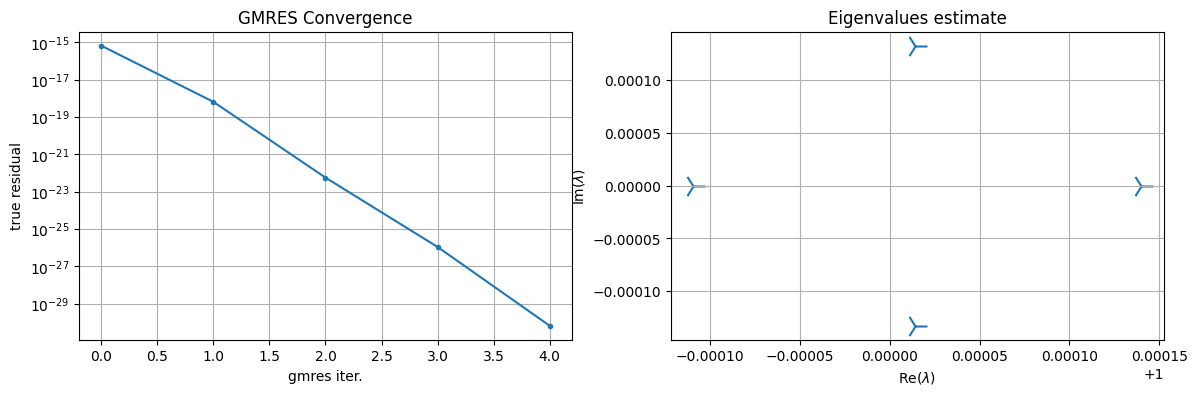

In [35]:
solve_petsc(Jfm_no_contact.mat, Jfm_no_contact_inv, rhs=Jfm_no_contact.local_rhs(rhs), pc_side='right', tol=1e-15)

Solve baseline took: 0.17
True residual decrease: 0.0017473061939955418
Solve multiplicative took: 0.33
True residual decrease: 0.001571811508374684


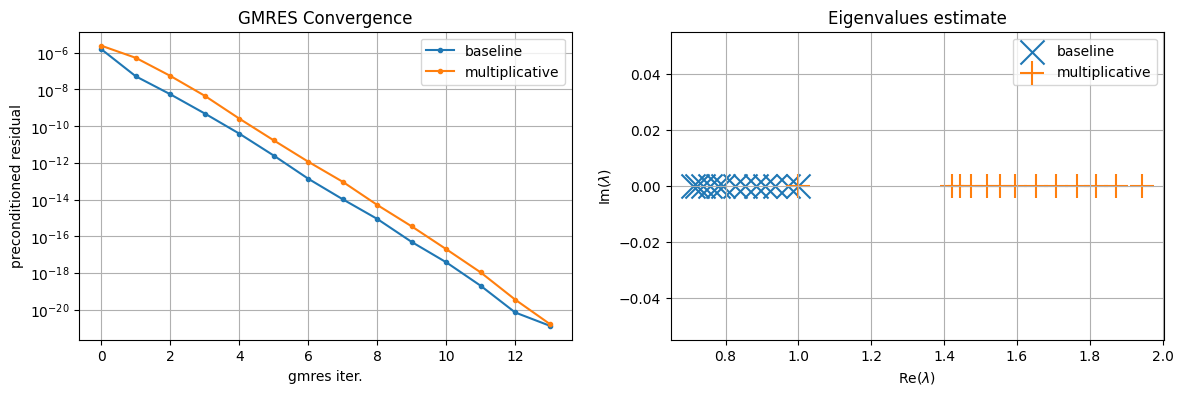

In [36]:
minv = Minv(J55_inv=Jfm_no_contact_inv, J45=J[4, save].mat)
mult_prec = MultiplicativePrec(first=minv, second=Jfm_stab_inv)

solve_petsc(Jfm.mat, Jfm_stab_inv, rhs=Jfm.local_rhs(rhs), label='baseline', pc_side='left', tol=1e-15)
solve_petsc(Jfm.mat, mult_prec, rhs=Jfm.local_rhs(rhs), label='multiplicative', pc_side='left', tol=1e-15)

Solve baseline took: 1.79
True residual decrease: 2.7899852328460013
PETSc Converged Reason: -5
lambda min: 81.33654584508979
Solve multiplicative took: 2.38
True residual decrease: 1.387544386780682
PETSc Converged Reason: -5
lambda min: 732.9963514455704


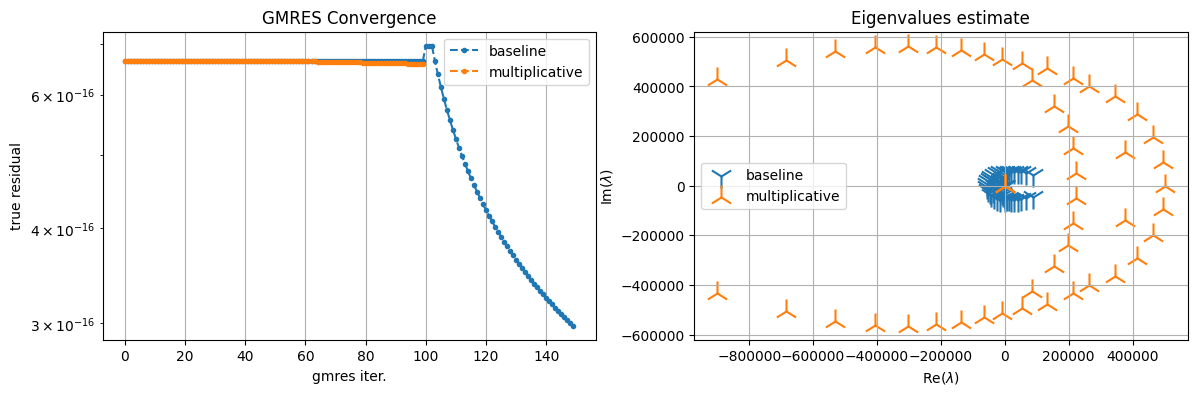

In [37]:
linv = Linv(J55_inv=Jfm_no_contact_inv, J54=J[save, 4].mat)
mult_prec = MultiplicativePrec(second=linv, first=Jfm_stab_inv)

solve_petsc(Jfm.mat, Jfm_stab_inv, rhs=Jfm.local_rhs(rhs), label='baseline', pc_side='right', tol=1e-15)
solve_petsc(Jfm.mat, mult_prec, rhs=Jfm.local_rhs(rhs), label='multiplicative', pc_side='right', tol=1e-15)